# Flower Vision - Flower Identification Model

### 1. Installing Required Libraries



In [17]:
!pip install pylops

### 2.Importing Necessary Libraries

In [18]:
# Import necessary libraries for data handling and visualization
import os
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from skimage import io
import pylops
from random import shuffle

# TensorFlow and Keras for model building and training
import tensorflow as tf 
import shutil
from tqdm import tqdm
import cv2
from glob import glob
from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

### 3. Setting path and other variables

In [19]:
# Define the path to the directory containing flower images
image_dir = Path('flowers')

# Retrieve file paths and corresponding labels from the directory structure
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Convert file paths and labels into a pandas DataFrame
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [20]:

image_df.head(5)

,Filepath,Label
0,../input/flowers-recognition/flowers/dandelion...,dandelion
1,../input/flowers-recognition/flowers/dandelion...,dandelion
2,../input/flowers-recognition/flowers/dandelion...,dandelion
3,../input/flowers-recognition/flowers/dandelion...,dandelion
4,../input/flowers-recognition/flowers/dandelion...,dandelion


In [21]:
image_df.shape

(4317, 2)

In [22]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,../input/flowers-recognition/flowers/daisy/163...,daisy
1,../input/flowers-recognition/flowers/tulip/566...,tulip
2,../input/flowers-recognition/flowers/rose/1599...,rose
3,../input/flowers-recognition/flowers/rose/7481...,rose
4,../input/flowers-recognition/flowers/dandelion...,dandelion


### 3. Sample display of images

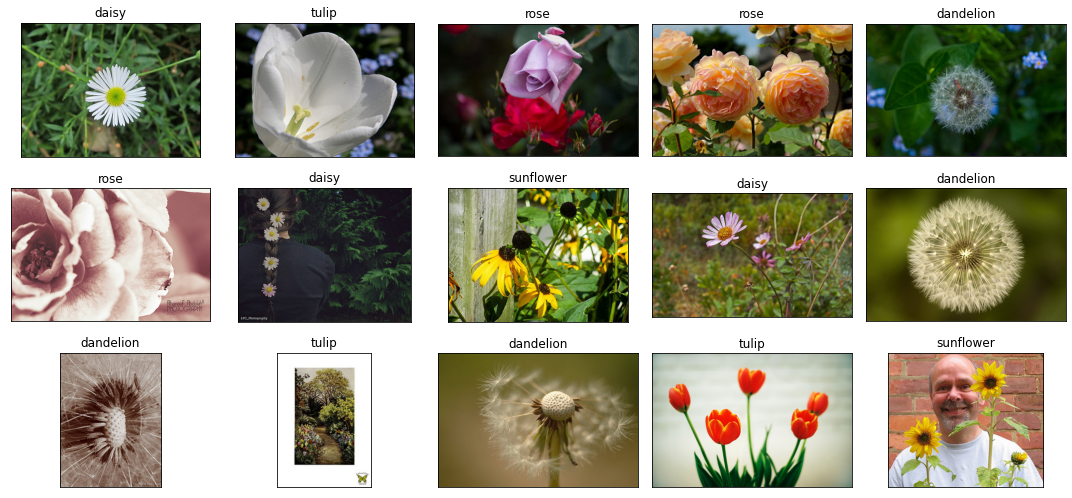

In [23]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

### 4. Splitting Data into Training and Testing Sets

In [24]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [25]:
train_df.shape

(3885, 2)

### 5.  Creating Image Data Generators

In [26]:
# Initialize ImageDataGenerator for training data with preprocessing and validation split
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
# Initialize ImageDataGenerator for test data with only preprocessing
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [27]:
train_df.head(5)

,Filepath,Label
3808,../input/flowers-recognition/flowers/dandelion...,dandelion
1858,../input/flowers-recognition/flowers/dandelion...,dandelion
2275,../input/flowers-recognition/flowers/tulip/242...,tulip
1909,../input/flowers-recognition/flowers/daisy/562...,daisy
1078,../input/flowers-recognition/flowers/sunflower...,sunflower


In [28]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3108 validated image filenames belonging to 5 classes.
Found 777 validated image filenames belonging to 5 classes.
Found 432 validated image filenames belonging to 5 classes.


### 6. Model Architecture

In [29]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(5, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [30]:
K.clear_session()
metrics = [
    'accuracy',
    'AUC'
]

# model = create_model((224, 224, 3))
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)
# model.save('models/checkpoint/EfficientNetB0.h5')


model = load_model('..EfficientNetB0.h5')


In [31]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

### 7. Training of the model

In [32]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
98/98 [==============================] - 57s 434ms/step - loss: 0.5388 - accuracy: 0.8131 - auc: 0.9398 - val_loss: 2.5252 - val_accuracy: 0.1686 - val_auc: 0.5125

Epoch 00001: val_loss improved from inf to 2.52518, saving model to models/EfficientNetB1/model_224.h5
Epoch 2/30
98/98 [==============================] - 37s 372ms/step - loss: 0.2959 - accuracy: 0.9070 - auc: 0.9775 - val_loss: 1.7103 - val_accuracy: 0.2728 - val_auc: 0.5584

Epoch 00002: val_loss improved from 2.52518 to 1.71031, saving model to models/EfficientNetB1/model_224.h5
Epoch 3/30
98/98 [==============================] - 36s 363ms/step - loss: 0.1842 - accuracy: 0.9369 - auc: 0.9902 - val_loss: 1.8717 - val_accuracy: 0.1429 - val_auc: 0.5182

Epoch 00003: val_loss did not improve from 1.71031
Epoch 4/30
98/98 [==============================] - 36s 363ms/step - loss: 0.2095 - accuracy: 0.9282 - auc: 0.9868 - val_loss: 2.8824 - val_accuracy: 0.2600 - val_auc: 0.5601

Epoch 00004: val_loss did not impro

### 8. Accuracy Graph of our Model

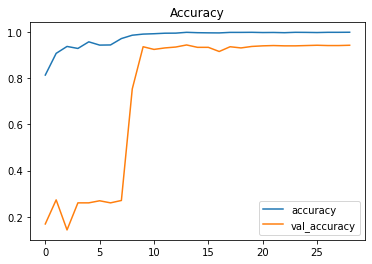

In [33]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [34]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.22357
Test Accuracy: 95.60%


#### Predicting the first five test flowers

In [35]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['tulip', 'rose', 'dandelion', 'tulip', 'tulip']


In [36]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       1.00      0.96      0.98        80
   dandelion       0.94      0.99      0.96        90
        rose       0.93      0.94      0.94        71
   sunflower       0.97      0.91      0.94        82
       tulip       0.95      0.96      0.95       109

    accuracy                           0.96       432
   macro avg       0.96      0.95      0.96       432
weighted avg       0.96      0.96      0.96       432



### 9. Confusiton matrix displaying the performance of model

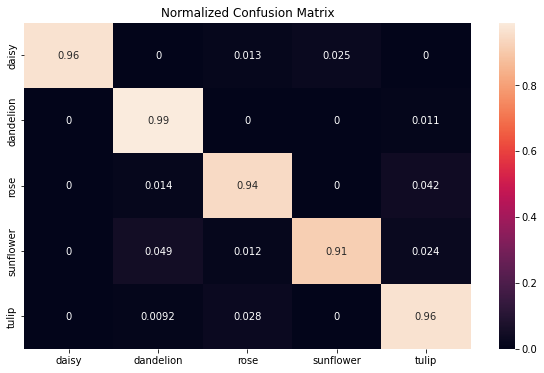

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Testing the model on every test data

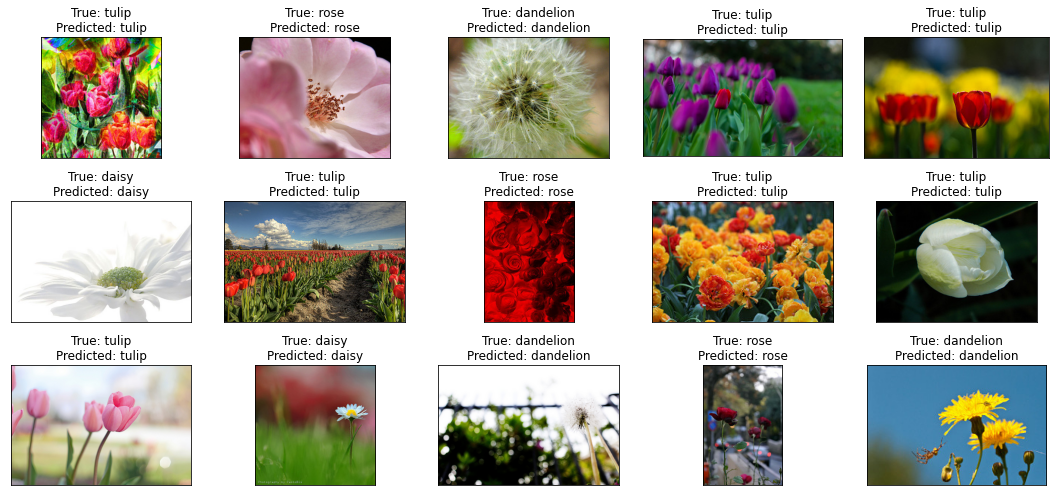

In [38]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

#### Introducing Blur Detection and Testing with a Random Image from Internet


In [39]:
image =io.imread('https://www.lovingly.com/wp-content/uploads/2019/09/red-rose-on-black-background.jpg',as_gray=True)

def detect_blur_fft(image, size=60, thresh=10):
    (h,w) = image.shape
    (cX, cY) = (int(w / 2.0), int(h / 2.0))
    fft = np.fft.fft2(image)
    fftShift = np.fft.fftshift(fft)
    fftShift[cY - size:cY + size, cX - size:cX + size] = 0
    fftShift = np.fft.ifftshift(fftShift)
    recon = np.fft.ifft2(fftShift)
    magnitude = 20 * np.log(np.abs(recon))
    mean = np.mean(magnitude)
    if mean <= thresh:
        return "Blurry"
    else:
        return "Not Blurry"

detect_blur_fft(image,60,10)

'Blurry'

### 10. Deblurring 

In [40]:
if detect_blur_fft(image) == 'Blurry':
    im = io.imread('https://www.lovingly.com/wp-content/uploads/2019/09/red-rose-on-black-background.jpg')[::5, ::5, 0]
    
    Nz, Nx = im.shape


    nh = [15, 25]
    hz = np.exp(-0.1*np.linspace(-(nh[0]//2), nh[0]//2, nh[0])**2)
    hx = np.exp(-0.03*np.linspace(-(nh[1]//2), nh[1]//2, nh[1])**2)
    hz /= np.trapz(hz) 
    hx /= np.trapz(hx) 
    h = hz[:, np.newaxis] * hx[np.newaxis, :]


    Cop = pylops.signalprocessing.Convolve2D(Nz * Nx, h=h,
                                             offset=(nh[0] // 2,
                                                     nh[1] // 2),
                                             dims=(Nz, Nx), dtype='float32')



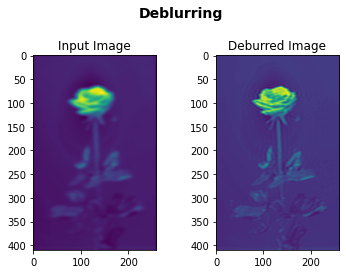

In [41]:
imblur = Cop * im.flatten()

imdeblur = \
    pylops.optimization.leastsquares.NormalEquationsInversion(Cop, None,
                                                              imblur,
                                                              maxiter=50)

Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet='haar', level=3)
Dop = [pylops.FirstDerivative(Nz * Nx, dims=(Nz, Nx), dir=0, edge=False),
       pylops.FirstDerivative(Nz * Nx, dims=(Nz, Nx), dir=1, edge=False)]
DWop = Dop + [Wop, ]



# Reshape images
imblur = imblur.reshape((Nz, Nx))
imdeblur = imdeblur.reshape((Nz, Nx))

fig = plt.figure()
fig.suptitle('Deblurring', fontsize=14, fontweight='bold', y=0.97 ,x =0.5)
plt.title("Blurred and Deblurred image")
ax = plt.subplot(121)
ax.set_title("Input Image")
plt.imshow(imblur)

ax = plt.subplot(122)
ax.set_title("Deburred Image")
plt.imshow(imdeblur)
plt.subplots_adjust(top=0.8)

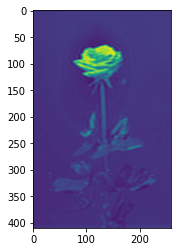

In [42]:
plt.imshow(imdeblur)
plt.savefig('deblured.jpg')

### Final Image Recognition

In [43]:
img_path = './deblured.jpg'
filepaths = pd.Series([img_path], name='Filepath').astype(str)
labels = pd.Series(['rose'], name='Label')

# Concatenate filepaths and labels
df = pd.concat([filepaths, labels], axis=1)


In [44]:
test_image = test_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


predictions = model.predict(test_image)

pred = np.argmax(predictions)

# Map the label
labels = test_image.class_indices
labels = dict((v,k) for k,v in labels.items())

print(labels[0])


Found 1 validated image filenames belonging to 1 classes.
rose
